<a href="https://colab.research.google.com/github/julesripoll/contrastive-learning/blob/main/Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup


In [20]:
%pip uninstall opencv-python-headless
%pip install opencv-python-headless==4.1.2.30
!pip install -U albumentations
import albumentations
albumentations.__version__

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtCore-bbdab771.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtGui-903938cd.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtTest-1183da5d.so.4.8.7
Proceed (y/n)? y
  Successfully uninstalled opencv-python-headless-4.1.2.30
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'1.2.0'

# Loading of the data

In [21]:
#import des données
!git clone https://github.com/axelcarlier/projsemisup.git
path = "./projsemisup/"

fatal: destination path 'projsemisup' already exists and is not an empty directory.


In [22]:
#import des classes
import csv
import pandas as pd
CLASSES = []
CLASSES_with_names = []

correspondances=pd.read_csv(path+"correspondances.csv",delimiter=";" )
with open(path + 'selected_classes.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=',', quotechar='"')
	for row in filereader:
		name=correspondances[correspondances["Taxon id"].isin([int(row[0])])]['Common Name'].values[0]
		CLASSES.append(row[0])
		CLASSES_with_names.append(name)

print(CLASSES_with_names)

['red fox', 'gray wolf', 'snail', 'lizard', 'spider', 'turtle', 'hippopotamus', 'mosquito', 'crocodile', 'oyster', 'ant', 'brown bear', 'black bear', 'chicken', 'beluga whale', 'humpback whale', 'whale shark', 'dolphin', 'eagle', 'deer', 'parrot', 'falcon', 'snake', 'penguin', 'giraffe', 'donkey', 'sheep', 'salamander', 'wombat', 'bee', 'bat', 'rabbit', 'pig', 'goats', 'koala', 'lion', 'jaguar', 'lynx', 'sea lion', 'great white shark', 'dog', 'elephant', 'cat', 'owl', 'squirrel', 'duck', 'frog', 'ibis', 'dairy cow', 'horse', 'butterfly', 'orangutan', 'kangaroo', 'mouse', 'turkey', 'baboon', 'moose', 'komodo dragon', 'antelope', 'ostrich', 'bison', 'water buffalo', 'beaver', 'hyena', 'swan', 'flamingo', 'hedgehog', 'raccoon', 'heron', 'sea otter', 'macaque', 'peafowl', 'pelican', 'warthog', 'polecat', 'killer whale', 'wallaby', 'hare', 'magpie', 'sea turtle', 'tortoise', 'badger', 'suricate', 'platypus', 'mole', 'Bouquetin des Alpes', 'Marmotte commune', 'Chien de prairie', 'porcepic', 

In [23]:
IMAGE_SIZE = 64

In [24]:
import os
import PIL
from PIL import Image
import numpy as np

#chargement sur le notebook
def load_semisup_data(path, classes, image_size=64):

  file_path_lab = os.listdir(path + 'Lab/')
  nb_lab = 475
  # Initialise les structures de données
  x_lab = np.zeros((nb_lab, image_size, image_size, 3))
  y_lab = np.zeros((nb_lab, 1))
  i = 0
  for c in file_path_lab:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Lab/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Lab/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)

      img = img.convert('RGB')
      # Remplissage de la variable x
      x_lab[i] = np.asarray(img)
      y_lab[i] = class_label
      i = i + 1


  file_path_test = os.listdir(path + 'Test/')
  nb_test = 2850
  # Initialise les structures de données
  x_test = np.zeros((nb_test, image_size, image_size, 3))
  y_test = np.zeros((nb_test, 1))
  i = 0
  for c in file_path_test:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Test/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Test/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_test[i] = np.asarray(img)
      y_test[i] = class_label
      i = i + 1
 
  file_path_unlab = os.listdir(path + 'Unlab/')
  nb_unlab = 9500
  # Initialise les structures de données
  x_unlab = np.zeros((nb_unlab, image_size, image_size, 3))

  i = 0
  for img_name in file_path_unlab:
    # Lecture de l'image
    img = Image.open(path + 'Unlab/' + img_name)
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.ANTIALIAS)
    img = img.convert('RGB')
    # Remplissage de la variable x
    x_unlab[i] = np.asarray(img)
    i = i + 1

  return x_lab, y_lab, x_unlab, x_test, y_test

In [25]:
x_lab, y_lab, x_unlab, x_test, y_test = load_semisup_data(path, CLASSES)
print(x_lab.shape, y_lab.shape)
print(x_unlab.shape)
print(x_test.shape, y_test.shape)

(475, 64, 64, 3) (475, 1)
(9500, 64, 64, 3)
(2850, 64, 64, 3) (2850, 1)


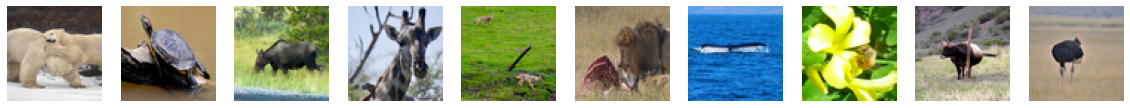

In [26]:
#visualisation de certaines images de notre ensemble test
import random as rd
import matplotlib.pyplot as plt
n = 10
idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[idx[i]].reshape(64, 64,3)/255.)
    ax.grid(False)
    plt.axis('off')
plt.show()

# Baseline 

In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

baseline = Sequential()

baseline.add(Conv2D(64,(3,3),input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),activation='relu'))
baseline.add(MaxPooling2D(pool_size=(2,2)))
baseline.add(Conv2D(128,(3,3),activation='relu'))
baseline.add(MaxPooling2D(pool_size=(2,2)))
baseline.add(Conv2D(256,(3,3),activation='relu'))
baseline.add(MaxPooling2D(pool_size=(2,2)))
baseline.add(Conv2D(256,(3,3),activation='relu'))
baseline.add(MaxPooling2D(pool_size=(2,2)))
baseline.add(Flatten())
baseline.add(Dense(512,activation='relu'))
baseline.add(Dropout(rate=0.2))
baseline.add(Dense(95,activation='softmax'))

baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)       

In [29]:
from albumentations.augmentations.transforms import Flip
import albumentations as A
from albumentations import Compose, Sequential, GaussianBlur, ColorJitter, HorizontalFlip, RandomResizedCrop, ToGray

def gen_augmentation(batch):
    """
    On prend en entrée une image, sous forme de np array 3 dimensions. On applique une séquence de transformations et on retourne l'image augmentée.
    """
    aug_batch=[]
    for i in range(len(batch)) :
        x=np.array(batch[i],dtype='uint8')
        data={'image':x}#.reshape(64,64,3)/255.
        transforms = Compose([
                Sequential([
                    RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE),
                    HorizontalFlip(p=0.5),
                    ColorJitter(p=0.8), #Peut etre des paramètres à ajuster
                    ToGray(p=0.2),
                    GaussianBlur(sigma_limit=(0.1, 2), blur_limit=(5, 5)),
                    ])
                ])
        aug_data=transforms(**data)
        aug_img=aug_data['image'] 
        aug_batch.append(aug_img)   
    return np.array(aug_batch)

def gen_augmentation_class(batch):
    """
    On prend en entrée une image, sous forme de np array 3 dimensions. On applique une séquence de transformations et on retourne l'image augmentée.
    """
    aug_batch=[]
    for i in range(len(batch)) :
        x=np.array(batch[i],dtype='uint8')
        data={'image':x}#.reshape(64,64,3)/255.
        transforms = Compose([
                Sequential([
                    RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE),
                    HorizontalFlip(p=0.5),
                    ])
                ])
        aug_data=transforms(**data)
        aug_img=aug_data['image'] 
        aug_batch.append(aug_img)   
    return np.array(aug_batch)


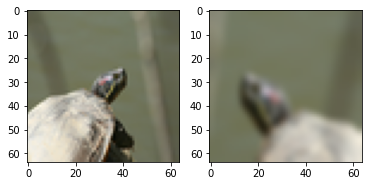

In [30]:
#puis on test avec notre tenseur test_tensor
augm_batch=gen_augmentation(x_lab[0:20])


#affichage des résultats
plt.subplot(1, 2, 1)
plt.imshow(x_lab[2]/255.)
plt.subplot(1, 2, 2)
plt.imshow(augm_batch[2])

In [49]:
#entrainement du modèle supervisé qui va nous servir de comparaison pour le simclr
import tensorflow as tf
import keras

epochs = 5
batch_size=2

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(
    learning_rate=3e-4,
)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
baseline.compile(loss=loss_fn, optimizer=optimizer, metrics=train_acc_metric)

history_baseline={'loss':[], 'train_acc':[], 'val_acc':[]}
steps_per_epoch = int(x_lab.shape[0]/batch_size)

y_true = y_lab
indices_lab = np.arange(x_lab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  for step in range(steps_per_epoch):
    # Sélection des données du prochain batch
    x_batch = x_lab[indices_lab[step*batch_size: (step+1)*batch_size]]
    y_batch = y_true[indices_lab[step*batch_size: (step+1)*batch_size]]

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:
      # Application du réseau aux données d'entrée
      x_batch_aug = gen_augmentation(x_batch)
      
      pred = baseline(x_batch_aug) 
  
      # Calcul de la fonction de perte sur ce batch
      loss_value = loss_fn(y_batch, pred)

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, baseline.trainable_weights)
      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, baseline.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch, pred)

  history_baseline['loss'].append(loss_value)
  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  history_baseline['train_acc'].append(train_acc)
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = baseline(x_test, training=False)
  val_acc_metric.update_state(y_test, val_logits)
  val_acc = val_acc_metric.result()
  history_baseline['val_acc'].append(val_acc)

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

Epoch    0 : Loss : 4.8158, Acc : 0.0654, Val Acc : 0.0526
Epoch    1 : Loss : 4.5002, Acc : 0.0738, Val Acc : 0.0519
Epoch    2 : Loss : 3.6805, Acc : 0.0717, Val Acc : 0.0744
Epoch    3 : Loss : 4.3040, Acc : 0.1055, Val Acc : 0.0877
Epoch    4 : Loss : 3.7186, Acc : 0.0844, Val Acc : 0.0768


In [54]:
#fonction pour plot n'importe quel historique entrainement
import matplotlib.pyplot as plt

def plot_training_analysis(history):

  epochs=range(len(history['loss']))
  if 'train_acc' in history.keys() :
    plt.plot(epochs, history['train_acc'], 'b', linestyle="--",label='Training acc')
    plt.plot(epochs, history['val_acc'], 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

  plt.figure()

  plt.plot(epochs, history['loss'], 'b', linestyle="--",label='Training loss')
  plt.title('Training  loss')
  plt.legend()

  plt.show()

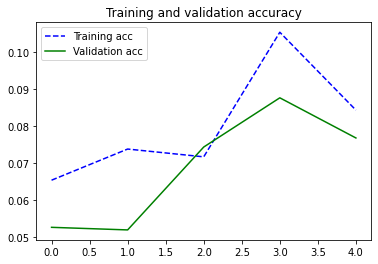

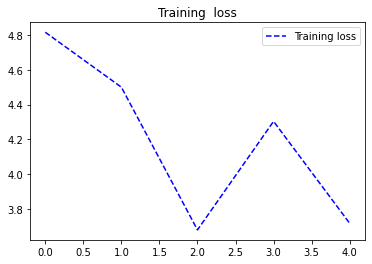

                     precision    recall  f1-score   support

            red fox       0.00      0.00      0.00        30
          gray wolf       0.00      0.00      0.00        30
              snail       0.12      0.07      0.09        30
             lizard       0.02      0.07      0.03        30
             spider       0.00      0.00      0.00        30
             turtle       0.00      0.00      0.00        30
       hippopotamus       0.00      0.00      0.00        30
           mosquito       0.42      0.17      0.24        30
          crocodile       0.00      0.00      0.00        30
             oyster       0.21      0.43      0.29        30
                ant       0.00      0.00      0.00        30
         brown bear       0.00      0.00      0.00        30
         black bear       0.06      0.03      0.04        30
            chicken       0.10      0.03      0.05        30
       beluga whale       0.33      0.57      0.42        30
     humpback whale    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
#visualisation des résultats de l'entrainement
from sklearn.metrics import classification_report, confusion_matrix

plot_training_analysis(history_baseline)

preds=baseline.predict(x_test)
y_pred_bool = np.argmax(preds, axis=1)
print(classification_report(y_test, y_pred_bool, target_names=CLASSES_with_names))

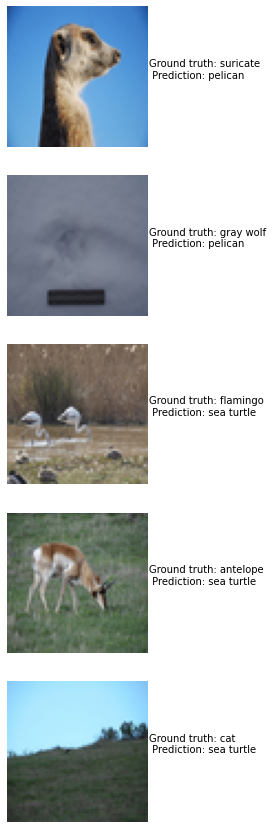

In [ ]:
#on visualise certaines prédictions
preds=baseline.predict(x_test)

fig, axes = plt.subplots(5, 1, figsize=(15, 15))
idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, 5)]

for i in range(5):
  axes[i].imshow(x_test[idx[i]]/255.)
  true_text = CLASSES_with_names[int(y_test[idx[i]])]
  pred_text = CLASSES_with_names[np.argmax(preds[idx[i]])]
  axes[i].axis('off')
  axes[i].text(64, 32, 'Ground truth: ' + true_text + '\n' + ' Prediction: ' + pred_text)

baseline.evaluate(x_test, y_test)

# Our custom SIMCLR

![picture](https://drive.google.com/uc?id=11cbtDX_TWtybq_y8KBRsfNu2UrwEPR9d)


In [ ]:
#architecture du simclr

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.models import Model

def create_models():
  #define encoder (common part to our 2 models)
  inputs = Input(shape=(x_unlab.shape[1:]), name='encoder_input')
  x = Conv2D(64,(3,3),activation='relu', padding='same')(inputs)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(128,(3,3),activation='relu', padding='same')(x)
  x = (MaxPooling2D(pool_size=(2,2)))(x)
  x = Conv2D(256,(3,3),activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Conv2D(256,(3,3),activation='relu', padding='same')(x)
  h = MaxPooling2D(pool_size=(2,2))(x)
  encoder = Model(inputs, h, name='encoder')

  #layers added to train SIMCLR
  #projecteur = Sequential()

  latent_inputs = Input(shape=(4,4,256), name='projecteur_input')
  flat=Flatten()(latent_inputs)
  #latent = GlobalAveragePooling2D()(latent_inputs)
  latent = Dense(256, activation="relu")(flat)
  z = Dense(128, activation="linear")(latent)
  projecteur = Model(latent_inputs, z, name='projecteur')
  outputs = projecteur(encoder(inputs))
  training_model = Model(inputs, outputs, name='SimCLR')
  
  #layer added to classify 
  cls_inputs = Input(shape=(4,4,256), name='cls_input')
  flat=Flatten()(cls_inputs)
  classification_layer=Dense(95, activation='softmax')(flat)
  classifier=Model(cls_inputs, classification_layer, name="classifier")
  cls_output=classifier(encoder(inputs))
  classif_model=Model(inputs, cls_output, name='classif_model')
  
  return training_model, classif_model, encoder
 
training_model, classif_model, encoder = create_models()
training_model.summary()

Model: "SimCLR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 4, 4, 256)         960896    
                                                                 
 projecteur (Functional)     (None, 128)               1081728   
                                                                 
Total params: 2,042,624
Trainable params: 2,042,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def contrastive_loss(zi, zj, temp):
        ''' this loss is the modified torch implementation by M Diephuis here: https://github.com/mdiephuis/SimCLR/
        the inputs:
        xi, xj: image features extracted from a batch of images 2N, composed of N matching paints
        tau: temperature parameter
        normalize: normalize or not. seem to not be very useful, so better to try without.
        '''

        n_samples = 2*zi.shape[0]
        zi_norm = tf.math.l2_normalize(zi, axis=1)
        zj_norm = tf.math.l2_normalize(zj, axis=1)
        z_norm = tf.keras.backend.concatenate((zi_norm, zj_norm), axis=0)

        # Matrice de similarité
        similarities = tf.matmul(z_norm, z_norm, transpose_b=True) 
        similarities = tf.keras.backend.exp(similarities/temp)

        # Similarité négative
        mask = np.ones((n_samples, n_samples), dtype=bool)
        np.fill_diagonal(mask, False)
        neg = tf.reshape(tf.boolean_mask(similarities, mask), [n_samples, -1])
        neg = tf.math.reduce_sum(neg, axis=-1)

        # Similarité positive
        pos = tf.math.reduce_sum(tf.math.multiply(zi_norm, zj_norm), axis=-1)
        pos = tf.keras.backend.exp(pos / temp)
        pos = tf.keras.backend.concatenate((pos, pos), axis=0)

        loss = tf.math.divide(pos, neg)
        loss = -tf.keras.backend.log(loss)
        return tf.math.reduce_mean(loss)

       

In [ ]:
"""Layer-wise Adaptive Rate Scaling optimizer for large-batch training."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.platform import tf_logging
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import linalg_ops
from tensorflow.python.ops import logging_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import variables
from tensorflow.python.training import optimizer
from tensorflow.python.training import training_ops
from tensorflow.python.training import training_util

class LARSOptimizer(optimizer.Optimizer):
  """Layer-wise Adaptive Rate Scaling for large batch training.

  Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
  I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)

  Implements the LARS learning rate scheme presented in the paper above. This
  optimizer is useful when scaling the batch size to up to 32K without
  significant performance degradation. It is recommended to use the optimizer
  in conjunction with:
      - Gradual learning rate warm-up
      - Linear learning rate scaling
      - Poly rule learning rate decay
  """

  def __init__(self,
               learning_rate,           # use linear scaling rule
               momentum=0.9,            # suggested by paper
               weight_decay=0.0001,     # suggested by paper
               eeta = 0.001,
               epsilon = 1e-5,
               name="LARSOptimizer"):
    """Construct a new LARS Optimizer.

    Args:
      learning_rate: A `Tensor` or floating point value. The base learning rate.
      momentum: A floating point value. Momentum hyperparameter.
      weight_decay: A floating point value. Weight decay hyperparameter.
      name: Optional name prefix for variables and ops created by LARSOptimizer.

    Raises:
      ValueError: If a hyperparameter is set to a non-sensical value.
    """
    if momentum < 0.0:
      raise ValueError(
          "momentum should be positive: %s" % momentum)
    if weight_decay < 0.0:
      raise ValueError(
          "weight_decay should be positive: %s" % weight_decay)
    super(LARSOptimizer, self).__init__(use_locking=False, name=name)

    self._learning_rate = learning_rate
    self._momentum = momentum
    self._weight_decay = weight_decay
    self._eeta = eeta
    self._epsilon = epsilon
    self._name = name

  def _create_slots(self, var_list):
    for v in var_list:
      self._zeros_slot(v, "momentum", self._name)

  def _apply_dense(self, grad, var):
    scaled_lr = self._learning_rate
    decayed_grad = grad
    #tf_logging.info("LARS: apply dense: %s", var.name)
    if 'batch_normalization' not in var.name and 'bias' not in var.name:
      #tf_logging.info("LARS: apply dense, decay: %s", var.name)
      w_norm = linalg_ops.norm(var, ord=2)
      g_norm = linalg_ops.norm(grad, ord=2)
      trust_ratio = array_ops.where(
          math_ops.greater(w_norm, 0),
          array_ops.where(
              math_ops.greater(g_norm, 0),
              (self._eeta * w_norm /
               (g_norm + self._weight_decay * w_norm + self._epsilon)),
              1.0),
          1.0)
      trust_ratio = clip_ops.clip_by_value(trust_ratio, 0.0, 50)
      scaled_lr = self._learning_rate * trust_ratio
      decayed_grad = grad  + self._weight_decay * var

    decayed_grad = clip_ops.clip_by_value(decayed_grad, -10.0, 10.0)
    mom = self.get_slot(var, "momentum")
    return training_ops.apply_momentum(
        var, mom,
        scaled_lr,
        decayed_grad,
        self._momentum,
        use_locking=False,
        use_nesterov=False)

  def _resource_apply_dense(self, grad, var):
    scaled_lr = self._learning_rate
    decayed_grad = grad
    #tf_logging.info("LARS: resouce apply dense: %s", var.name)
    w_norm = linalg_ops.norm(var, ord=2)
    g_norm = linalg_ops.norm(grad, ord=2)
    if 'batch_normalization' not in var.name and 'bias' not in var.name:
      #tf_logging.info("LARS: apply dense, decay: %s", var.name)
      trust_ratio = array_ops.where(
          math_ops.greater(w_norm, 0),
          array_ops.where(
              math_ops.greater(g_norm, 0),
              (self._eeta * w_norm /
               (g_norm + self._weight_decay * w_norm + self._epsilon)),
              1.0),
          1.0)
      trust_ratio = clip_ops.clip_by_value(trust_ratio, 0.0, 50)
      scaled_lr = self._learning_rate * trust_ratio
      decayed_grad = grad + self._weight_decay * var

    decayed_grad = clip_ops.clip_by_value(decayed_grad, -10.0, 10.0)
    mom = self.get_slot(var, "momentum")
    return training_ops.resource_apply_momentum(
        var.handle, mom.handle,
        scaled_lr,
        decayed_grad,
        self._momentum,
        use_locking=False,
        use_nesterov=False)

In [ ]:
#entrainement de l'encodeur et du projecteur (f et g).
from tensorflow import keras
 
#boucle custom training
batch_size=256
epochs=2
history_training={'loss':[]}
indices_unlab = np.arange(x_unlab.shape[0])
initial_learning_rate = 0.075*(batch_size**0.5)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = LARSOptimizer(learning_rate=initial_learning_rate, weight_decay=10**-6)
loss_fn = contrastive_loss

steps_per_epoch = int(x_unlab.shape[0]/batch_size)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=steps_per_epoch*epochs)

for epoch in range(epochs):
  cum_loss_value = 0
  global_step = 0
  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_unlab)

  for step in range(steps_per_epoch):
    # Sélection des données du prochain batch
    x_batch = x_unlab[indices_unlab[step*batch_size: (step+1)*batch_size]]

    # Nouveau lr issu du schedule
    global_step += 1
    if epoch > 10:
      lr = lr_decayed_fn(global_step)
      optimizer._learning_rate = lr

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:
      # Application du réseau aux données d'entrée
      x_batch1=gen_augmentation(x_batch)
      x_batch2=gen_augmentation(x_batch)
      
      z_pred1 = training_model(x_batch1) 
      z_pred2 = training_model(x_batch2) 

      # Calcul de la fonction de perte sur ce batch
      loss_value = loss_fn(z_pred1, z_pred2, temp=0.1)

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, training_model.trainable_weights)
      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, training_model.trainable_weights))

  history_training['loss'].append(loss_value)
  print("epoch", epoch, "Loss", loss_value)
  if (epoch % 5 == 0) or (epoch==epochs-1):
    training_model.save_weights(checkpoint_path.format(epoch=epoch)) 


epoch 0 Loss tf.Tensor(5.2191105, shape=(), dtype=float32)
epoch 1 Loss tf.Tensor(4.754612, shape=(), dtype=float32)


In [56]:
plot_training_analysis(history_training)

NameError: ignored

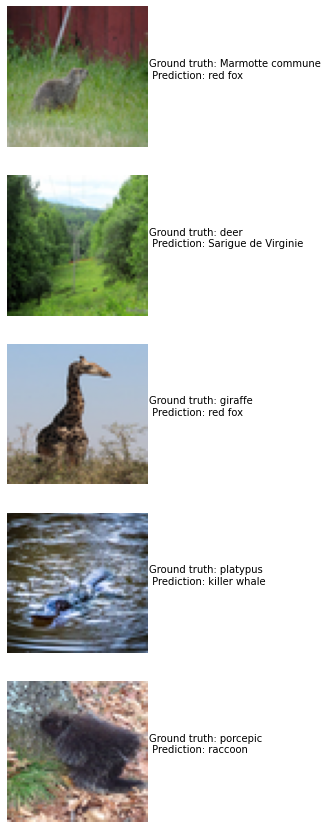

In [ ]:
#visu des classifications réalisées par le modèle sans que le module de classif ait été entrainé

preds=classif_model.predict(x_test)

fig, axes = plt.subplots(5, 1, figsize=(15, 15))
idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, 5)]

for i in range(5):
  axes[i].imshow(x_test[idx[i]]/255.)
  true_text = CLASSES_with_names[int(y_test[idx[i]])]
  pred_text = CLASSES_with_names[np.argmax(preds[idx[i]])]
  axes[i].axis('off')
  axes[i].text(64, 32, 'Ground truth: ' + true_text + '\n' + ' Prediction: ' + pred_text)

#classif_model.evaluate(x_test, np.expand_dims(y_test,1))

In [ ]:
encoder.trainable = False
classif_model.summary()

Model: "classif_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 4, 4, 256)         960896    
                                                                 
 classifier (Functional)     (None, 95)                389215    
                                                                 
Total params: 1,350,111
Trainable params: 389,215
Non-trainable params: 960,896
_________________________________________________________________


In [ ]:
#entrainement du module de classif

batch_size = 256
epochs = 2
steps_per_epoch = int(x_lab.shape[0]/batch_size)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.1,
)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
classif_model.compile(loss=loss_fn, optimizer=optimizer, metrics=train_acc_metric)

y_true = y_lab
indices_lab = np.arange(x_lab.shape[0])
history_classif={'loss': [], 'train_acc': [], 'val_acc':[]}

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  for step in range(steps_per_epoch):
    # Sélection des données du prochain batch
    x_batch = x_lab[indices_lab[step*batch_size: (step+1)*batch_size]]
    y_batch = y_true[indices_lab[step*batch_size: (step+1)*batch_size]]

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:
      # Application du réseau aux données d'entrée
      x_batch_aug = gen_augmentation_class(x_batch)
      
      pred = classif_model(x_batch_aug) 
  
      # Calcul de la fonction de perte sur ce batch
      loss_value = loss_fn(y_batch, pred)

     
      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, classif_model.trainable_weights)
      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, classif_model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch, pred)
  history_classif['loss'].append(loss_value)
  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  history_classif['train_acc'].append(train_acc)
  # Calcul de la précision sur l'ensemble de validation à la fin de l'epoch
  val_logits = classif_model(x_test, training=False)
  val_acc_metric.update_state(y_test, val_logits)
  val_acc = val_acc_metric.result()
  history_classif['val_acc'].append(val_acc)
  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Val Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(val_acc)))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()

  #if (epoch % 5 == 0) or (epoch==epochs-1):
  #  classif_model.save_weights(checkpoint_path.format(epoch=epoch))

#classif_model.fit(x_lab_aug, y_true, epochs=30, batch_size=batch_size)
#classif_model.evaluate(x_lab, y_true)

Epoch    0 : Loss : 12.1215, Acc : 0.0078, Val Acc : 0.0495
Epoch    1 : Loss : 389.4035, Acc : 0.0742, Val Acc : 0.0239


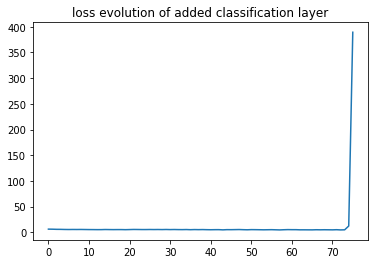

In [ ]:
plot_training_analysis(history_classif)

In [ ]:
#note : classif model c'est en fait notre modèle final, simclr donc
classif_model.evaluate(x_test, y_test)

90/90 [==============================] - 1s 9ms/step - loss: 759.0205 - sparse_categorical_accuracy: 0.0239


[759.0205078125, 0.023859649896621704]

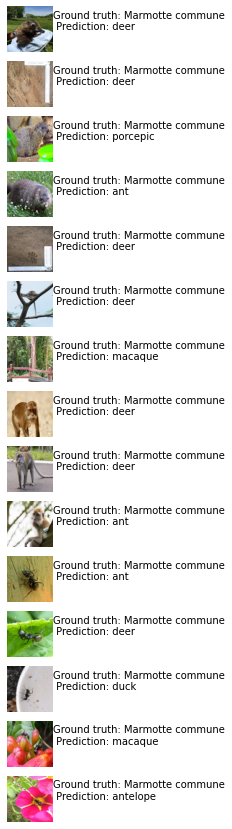

In [ ]:
#visu de certaines prédictions

preds=classif_model.predict(x_test)

fig, axes = plt.subplots(5, 1, figsize=(15, 15))
idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, 5)]

for i in range(5):
  axes[i].imshow(x_test[idx[i]]/255.)
  true_text = CLASSES_with_names[int(y_test[idx[i]])]
  pred_text = CLASSES_with_names[np.argmax(preds[idx[i]])]
  axes[i].axis('off')
  axes[i].text(64, 32, 'Ground truth: ' + true_text + '\n' + ' Prediction: ' + pred_text)

In [ ]:
#fine tuning de tout : f, g, et le module de classif à la fin

encoder.trainable = True

optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00001,
)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
classif_model.compile(loss=loss_fn, optimizer=optimizer, metrics=train_acc_metric)

classif_model.fit(x_lab, y_lab, shuffle=True, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
15/15 [==============================] - 2s 87ms/step - loss: 692.2523 - sparse_categorical_accuracy: 0.0505 - val_loss: 571.3649 - val_sparse_categorical_accuracy: 0.0256
Epoch 2/10
15/15 [==============================] - 1s 46ms/step - loss: 521.4024 - sparse_categorical_accuracy: 0.0568 - val_loss: 437.6369 - val_sparse_categorical_accuracy: 0.0274
Epoch 3/10
15/15 [==============================] - 1s 58ms/step - loss: 403.0990 - sparse_categorical_accuracy: 0.0568 - val_loss: 332.7103 - val_sparse_categorical_accuracy: 0.0267
Epoch 4/10
15/15 [==============================] - 1s 46ms/step - loss: 305.6904 - sparse_categorical_accuracy: 0.0547 - val_loss: 251.7483 - val_sparse_categorical_accuracy: 0.0242
Epoch 5/10
15/15 [==============================] - 1s 46ms/step - loss: 227.7013 - sparse_categorical_accuracy: 0.0589 - val_loss: 184.4454 - val_sparse_categorical_accuracy: 0.0218
Epoch 6/10
15/15 [==============================] - 1s 57ms/step - loss: 164.2077 - s

90/90 [==============================] - 1s 7ms/step - loss: 22.1454 - sparse_categorical_accuracy: 0.0221


[22.14535903930664, 0.0221052635461092]

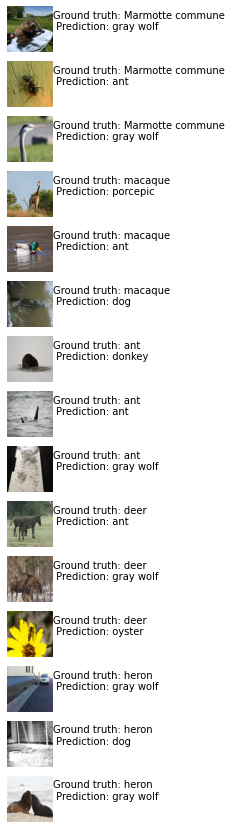

In [ ]:
#éval des prédictions réalisées après le fine tuning.

preds=classif_model.predict(x_test)

fig, axes = plt.subplots(5, 1, figsize=(15, 15))
idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, 5)]

for i in range(5):
  axes[i].imshow(x_test[idx[i]]/255.)
  true_text = CLASSES_with_names[int(y_test[idx[i]])]
  pred_text = CLASSES_with_names[np.argmax(preds[idx[i]])]
  axes[i].axis('off')
  axes[i].text(64, 32, 'Ground truth: ' + true_text + '\n' + ' Prediction: ' + pred_text)

classif_model.evaluate(x_test, np.expand_dims(y_test,1))